In [1]:
import numpy as np
from typing import List, Tuple
import gymnasium as gym
import matplotlib.pyplot as plt
import random

general_seed = 95
random.seed(general_seed)


def initialize_random_q_table(env):
    new_seed = random.randint(1, 100000)
    np.random.seed(new_seed)
    q_table = np.random.uniform(low=0, high=0.1, size=(env.observation_space.n, env.action_space.n))
    q_table[(env.desc == b"G").flatten()] = 0  # Ensure the goal state has Q-values of 0

    return q_table


def epsilon_greedy_policy(q_table, state, epsilon, env):

    if np.random.random() < epsilon:
        action = env.action_space.sample()
        return action
    else:
        return np.argmax(q_table[state])  # Exploit: choose best action


def train_q_learning(
        env: gym.Env,
        q_table_list,
        alpha: float = 0.1,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.999,
        episodes: int = 10000,
        num_runs: int = 3,
):
    """Trains an agent using the Q-learning algorithm on a specified environment and performs multiple runs for statistical analysis."""
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"QL: Run {run_idx + 1} / {num_runs}")

        q_table = np.copy(q_table_list[run_idx])
        # env.action_space.seed(seeds[run_idx])

        env.reset()
        epsilon = initial_epsilon

        for episode in range(episodes):
            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset()[0]
            truncated, done = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection
                action = epsilon_greedy_policy(q_table, state, epsilon, env)

                next_state, reward, done, truncated, _ = env.step(action)

                # Q-Learning update rule
                q_table[state, action] = q_table[state, action] + alpha * (
                        reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
                )
                state = next_state

            # Epsilon decay
            avg_epsilon_list[run_idx][episode] = epsilon
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            # Evaluate current q-table
            avg_steps, success_rate, avg_reward = evaluation_policy(env, q_table)

            # Append the evaluation metrics for this run
            avg_steps_list[run_idx][episode] = avg_steps
            avg_success_rate_list[run_idx][episode] = success_rate
            avg_reward_list[run_idx][episode] = avg_reward

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        # print(f"Average steps per episode over {num_runs} runs: {avg_steps_over_runs}")
        # print(f"Average success rate over {num_runs} runs: {avg_success_rate_over_runs}")
        # print(f"Average reward per episode over {num_runs} runs: {avg_reward_over_runs}")
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)

    print("QL is Done!")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def train_double_q_learning(
        env: gym.Env,
        q_table_list,
        alpha: float = 0.1,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.999,
        episodes: int = 10000,
        num_runs: int = 3,
):
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment and performs multiple runs.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        num_runs (int): Number of runs for statistical analysis.

    Returns: Q-tables
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"DQL: Run {run_idx + 1} / {num_runs}")

        q_table_a = np.copy(q_table_list[run_idx])
        # q_table_a = np.zeros((env.observation_space.n, env.action_space.n))
        q_table_b = np.copy(q_table_a)

        env.reset()

        epsilon = initial_epsilon

        for episode in range(episodes):

            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()  # Fix if reset returns tuple
            done, truncated = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection using the average of Q-tables A and B
                action = epsilon_greedy_policy((q_table_b + q_table_a) / 2, state=state, epsilon=epsilon, env=env)

                next_state, reward, done, truncated, _ = env.step(action)

                if np.random.uniform(0, 1) < 0.5:
                    best_next_action = np.argmax(q_table_a[next_state, :])
                    td_target = reward + gamma * q_table_b[next_state, best_next_action]
                    q_table_a[state, action] += alpha * (td_target - q_table_a[state, action])
                else:
                    best_next_action = np.argmax(q_table_b[next_state, :])
                    td_target = reward + gamma * q_table_a[next_state, best_next_action]
                    q_table_b[state, action] += alpha * (td_target - q_table_b[state, action])
                state = next_state

            # Epsilon decay
            avg_epsilon_list[run_idx][episode] = epsilon
            epsilon = max(min_epsilon, epsilon_decay * epsilon)

            if episode % 1 == 0:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, (q_table_b + q_table_a) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print("Double Q-learning multiple runs completed.")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def asynchronous_speedy_q_learning(
        env,
        q_table_list,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.9999,
        total_time_steps: int = 200000,
        episodes=100,
        num_runs: int = 3,
):
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):

        print(f"SQL: Run {run_idx + 1} / {num_runs}")
        Q_k = np.copy(q_table_list[run_idx])
        Q_k_minus_1 = np.copy(Q_k)

        env.reset()

        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        alpha = 1

        k = 0
        N = np.zeros((state_space, action_space), dtype=int)
        state = env.reset()[0]
        t = 0

        epsilon = initial_epsilon

        done, truncated = False, False
        lake_map = env.desc
        frozen_lake_binary = np.array((lake_map != b'H') & (lake_map != b'G')).astype(int).flatten()

        episode = 0
        while t <= total_time_steps and episode < episodes:
            action = epsilon_greedy_policy(Q_k, state, epsilon, env)
            next_state, reward, done, truncated, _ = env.step(action)

            eta = 1 / (N[state][action] + 1)

            # Compute temporal differences
            best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
            best_next_action_k = np.argmax(Q_k[next_state])
            T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (
                    reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
            T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (
                    reward + gamma * Q_k[next_state, best_next_action_k])

            # Update Q_k+1
            Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k - 1) * T_kQ_k_minus_1)
            N[state][action] += 1

            # Update Q-table references
            Q_k_minus_1 = np.copy(Q_k)
            Q_k[state, action] = np.copy(Q_k_plus_1)

            state = next_state

            # Check if all state-action pairs have been visited
            if np.min(N[frozen_lake_binary == 1]) > 0:
                k += 1
                alpha = 1 / (k + 1)
                N.fill(0)  # Reset visit counts
                print("N got reset")


            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, Q_k)
                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                episode += 1
                state = env.reset()[0]
                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)
                epsilon = max(min_epsilon, epsilon_decay * epsilon)

        # if episode < episodes:
        #     avg_success_rate_list[run_idx][episode+1:episodes] = np.ones((episode+1, episodes))
        #     avg_reward_list[run_idx][episode+1:episodes] = np.ones((episode+1, episodes))

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print(f"episode ended in SQL: {episode}")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def ultimate_sdql_training(
        env,
        q_table_list,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.9999,
        total_time_steps: int = 200000,
        episodes=100,
        num_runs: int = 3,
) -> Tuple:
    """
    Trains an agent using the Ultimate Speedy Double Q-learning (SDQL) algorithm over multiple runs for statistical analysis.

    Args:
        env: The environment to train the agent on.
        epsilon: Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon: Minimum value that epsilon can decay to.
        epsilon_decay: Rate at which epsilon decays after each step.
        T: Total number of time steps.
        gamma: Discount factor for future rewards.
        eval_interval: Frequency of evaluation during training.
        eval_episodes: Number of episodes to run during evaluation.
        num_runs: Number of runs for statistical analysis.
        seeds: List of seeds for reproducibility.

    Returns:
        A tuple containing:
        - Average cumulative rewards across all runs.
        - Standard deviation of rewards.
        - Average episode lengths.
        - Standard deviation of episode lengths.
        - Average epsilon values.
        - Standard deviation of epsilon values.
        - Time steps.
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"SDQL: Run {run_idx + 1} / {num_runs}")

        env.reset()

        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        Q_A = np.copy(q_table_list[run_idx])
        Q_B = np.copy(Q_A)
        Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

        N_A = np.zeros((state_space, action_space))
        N_B = np.zeros((state_space, action_space))

        k_A = k_B = t = 0
        alpha_A = alpha_B = 1

        state = env.reset()[0]

        lake_map = env.desc
        frozen_lake_binary = np.array((lake_map != b'H') & (lake_map != b'G')).astype(int).flatten()
        epsilon = initial_epsilon

        episode = 0
        while t <= total_time_steps and episode < episodes:

            action = epsilon_greedy_policy(Q_A, state, epsilon, env)

            next_state, reward, done, truncated, _ = env.step(action)

            if np.random.uniform(0, 1) < 0.5:  # Update Q_A
                eta = 1 / (N_A[state, action] + 1)
                a_star = np.argmax(Q_A_minus_1[next_state, :])
                a_plus = np.argmax(Q_A[next_state, :])

                T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (
                        reward + gamma * Q_B_minus_1[next_state, a_star])
                T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (
                        reward + gamma * Q_B[next_state, a_plus])

                Q_A_minus_1[state, action] = Q_A[state, action]
                Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (
                        k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
                N_A[state, action] += 1
            else:  # Update Q_B
                eta = 1 / (N_B[state, action] + 1)
                a_star = np.argmax(Q_B_minus_1[next_state, :])
                a_plus = np.argmax(Q_B[next_state, :])
                T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                        reward + gamma * Q_A_minus_1[next_state, a_star])
                T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (
                        reward + gamma * Q_A[next_state, a_plus])

                Q_B_minus_1[state, action] = Q_B[state, action]
                Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                        k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
                N_B[state, action] += 1

            state = next_state

            # Update counters and learning rates if needed
            if np.min(N_A[frozen_lake_binary == 1]) > 0:
                k_A += 1
                alpha_A = 1 / (k_A + 1)
                N_A.fill(0)  # Reset visit counts for A

            if np.min(N_B[frozen_lake_binary == 1]) > 0:
                k_B += 1
                alpha_B = 1 / (k_B + 1)
                N_B.fill(0)  # Reset visit counts for B


            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, (Q_A + Q_B) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                episode += 1
                state = env.reset()[0]
                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)
                epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print(f"episode ended in SDQL: {episode}")

    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def evaluation_policy(env, q_table):
    """
    Evaluates the agent's policy using the Q-table by running a number of episodes.
    Tracks the number of steps, success rate, and total rewards.

    Parameters:
        env: gym.Env - The environment.
        q_table: np.array - The Q-table for the agent.

    Returns:
        A tuple of (average steps, average success rate, average reward).
    """
    total_successes = 0

    state = env.reset()[0]  # Reset the environment at the start of each episode
    done, truncated = False, False

    episode_steps = 0
    episode_reward = 0

    while not (done or truncated):
        # Choose the best action from Q-table (greedy policy)
        action = np.argmax(q_table[state])

        next_state, reward, done, truncated, _ = env.step(action)

        episode_reward += reward
        episode_steps += 1

        state = next_state

    if reward == 1:  # If the agent reached the goal
        total_successes += 1

    return episode_steps, total_successes, episode_reward

def plot_comparison_results(algorithms_results, algorithms_names, episodes=2000):
    plt.figure(figsize=(12, 12))

    # Plot average steps for each algorithm with std
    plt.subplot(3, 1, 1)
    for i, result in enumerate(algorithms_results):
        avg_steps_over_runs = result[0]
        std_steps_over_runs = result[1]

        # Plot the mean line
        plt.plot(range(episodes), avg_steps_over_runs, label=f"{algorithms_names[i]} - Avg Steps")
        # Plot the shadow (std deviation)
        plt.fill_between(range(episodes),
                         avg_steps_over_runs - std_steps_over_runs,
                         avg_steps_over_runs + std_steps_over_runs,
                         alpha=0.3)  # Change alpha to adjust visibility of shadow
    plt.title("Average Steps per Episode with Std Deviation")
    plt.xlabel("Episodes")
    plt.ylabel("Average Steps")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot average success rate for each algorithm (No std necessary here)
    plt.subplot(3, 1, 2)
    for i, result in enumerate(algorithms_results):
        avg_success_rate_over_runs = result[2]
        plt.plot(range(episodes), avg_success_rate_over_runs, label=f"{algorithms_names[i]} - Success Rate")
    plt.title("Average Success Rate per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Success Rate")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot average reward for each algorithm with std
    plt.subplot(3, 1, 3)
    for i, result in enumerate(algorithms_results):
        avg_reward_over_runs = result[3]
        std_reward_over_runs = result[4]

        # Plot the mean line
        plt.plot(range(episodes), avg_reward_over_runs, label=f"{algorithms_names[i]} - Avg Reward")
        # Plot the shadow (std deviation)
        plt.fill_between(range(episodes),
                         avg_reward_over_runs - std_reward_over_runs,
                         avg_reward_over_runs + std_reward_over_runs,
                         alpha=0.3)  # Change alpha to adjust visibility of shadow
    plt.title("Average Reward per Episode with Std Deviation")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


def compare_algorithms(results, titles, save_path="comparison_plot.png"):
    # Create a figure with 4 rows and 1 column, slightly smaller figure size
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))  # Increased the size for more space

    # Hardcoded colors for plotting
    colors = ['b', 'g', 'r', 'purple']

    # Plot Average Steps with Std Deviation (Shadows)
    ax1 = axes[0]
    for i, (avg_steps, _, _, _, std_steps, _) in enumerate(results):
        ax1.plot(avg_steps, color=colors[i], label=f'{titles[i]}')
        ax1.fill_between(range(len(avg_steps)),
                         np.array(avg_steps) - np.array(std_steps),
                         np.array(avg_steps) + np.array(std_steps),
                         color=colors[i], alpha=0.2)
    ax1.set_title("Steps per Episode", fontsize=14)
    ax1.set_xlabel("Episode", fontsize=12)
    ax1.set_ylabel("Steps", fontsize=12)

    # Plot Average Success Rate (No Std Deviation Needed)
    ax2 = axes[1]
    for i, (_, avg_success_rate, _, _, _, _) in enumerate(results):
        ax2.plot(avg_success_rate, color=colors[i], label=f'{titles[i]}')
    ax2.set_title("Cumulative Success Rate per Episode", fontsize=14)
    ax2.set_xlabel("Episode", fontsize=12)
    ax2.set_ylabel("Success Rate", fontsize=12)

    # Plot Average Reward with Std Deviation (Shadows)
    ax3 = axes[2]
    for i, (_, _, avg_rewards, _, _, std_rewards) in enumerate(results):
        ax3.plot(avg_rewards, color=colors[i], label=f'{titles[i]}')
        ax3.fill_between(range(len(avg_rewards)),
                         np.array(avg_rewards) - np.array(std_rewards),
                         np.array(avg_rewards) + np.array(std_rewards),
                         color=colors[i], alpha=0.2)
    ax3.set_title("Cumulative Reward per Episode", fontsize=14)
    ax3.set_xlabel("Episode", fontsize=12)
    ax3.set_ylabel("Reward", fontsize=12)

    # Plot Epsilon Decay (Assuming You Have Epsilon Data to Plot)
    ax4 = axes[3]
    for i, (_, _, _, avg_epsilons, _, _) in enumerate(results):
        ax4.plot(avg_epsilons, color=colors[i], label=f'{titles[i]}')
    ax4.set_title("Epsilon Decay", fontsize=14)
    ax4.set_xlabel("Episode", fontsize=12)
    ax4.set_ylabel("Epsilon Value", fontsize=12)

    # Add a legend common for all plots, move it to the bottom
    fig.legend(labels=titles, loc='lower center', ncol=len(titles), fontsize='medium', bbox_to_anchor=(0.5, -0.05))

    # Add more vertical space between subplots to avoid overlap
    plt.subplots_adjust(hspace=0.5)  # Increased vertical spacing between plots

    # Adjust the layout to fit all elements and avoid overlap
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.text(0.1, 0.1, f"Seed: {general_seed}", transform=plt.gca().transAxes,
             fontsize=10, color='gray', alpha=0.7)

    # Save and show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Adjust to prevent clipping
    plt.show()


env = gym.make('FrozenLake-v1', is_slippery=False)

num_runs = 20

env = gym.make('FrozenLake-v1', is_slippery=False)
q_list = [initialize_random_q_table(env) for _ in range(num_runs)]
episodes = 2000
# Train the algorithms and store results
q_learning_results = train_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.9995)
env.reset()
double_q_learning_results = train_double_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.9995)
env.reset()
asynchronous_speedy_q_learning_results = asynchronous_speedy_q_learning(env, q_list, num_runs=num_runs, episodes=episodes,
                                                                        epsilon_decay=0.9995)
env.reset()
ultimate_sdql_results = ultimate_sdql_training(env, q_list, num_runs=num_runs, episodes=episodes, epsilon_decay=0.9995)

# Store the results in a list
algorithms_results = [
    q_learning_results,
    double_q_learning_results,
    asynchronous_speedy_q_learning_results,
    ultimate_sdql_results
]

# Corresponding algorithm names
algorithms_names = [
    "Q-Learning",
    "DQL",
    "SQL",
    "SDQL"
]

# Plot comparison of all algorithms
# plot_comparison_results(algorithms_results, algorithms_names, episodes=1000)
compare_algorithms(algorithms_results, algorithms_names)

ModuleNotFoundError: No module named 'gym'

QL: Run 1 / 20
QL: Run 2 / 20
QL: Run 3 / 20
QL: Run 4 / 20
QL: Run 5 / 20
QL: Run 6 / 20
QL: Run 7 / 20
QL: Run 8 / 20
QL: Run 9 / 20
QL: Run 10 / 20
QL: Run 11 / 20
QL: Run 12 / 20
QL: Run 13 / 20
QL: Run 14 / 20
QL: Run 15 / 20
QL: Run 16 / 20
QL: Run 17 / 20
QL: Run 18 / 20
QL: Run 19 / 20
QL: Run 20 / 20
QL is Done!
DQL: Run 1 / 20
DQL: Run 2 / 20
DQL: Run 3 / 20
DQL: Run 4 / 20
DQL: Run 5 / 20
DQL: Run 6 / 20
DQL: Run 7 / 20
DQL: Run 8 / 20
DQL: Run 9 / 20
DQL: Run 10 / 20
DQL: Run 11 / 20
DQL: Run 12 / 20
DQL: Run 13 / 20
DQL: Run 14 / 20
DQL: Run 15 / 20
DQL: Run 16 / 20
DQL: Run 17 / 20
DQL: Run 18 / 20
DQL: Run 19 / 20
DQL: Run 20 / 20
Double Q-learning multiple runs completed.
SQL: Run 1 / 20
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
SQL: Run 2 / 20
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got reset
N got r

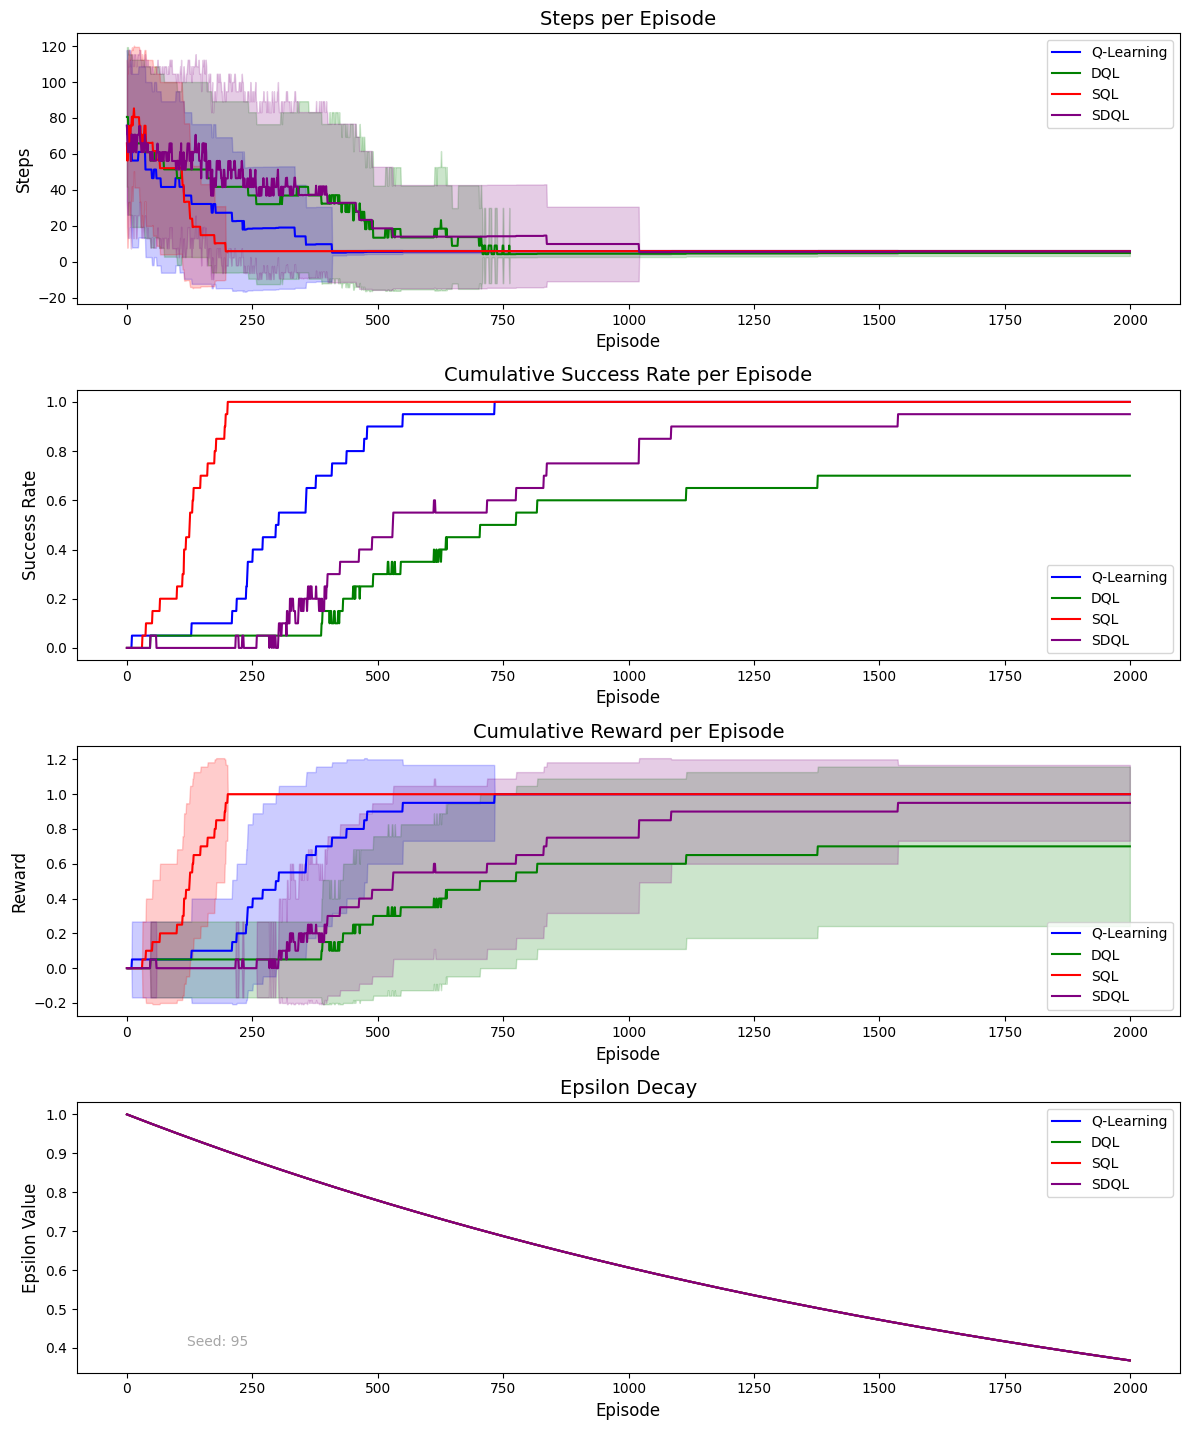

In [7]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
import gymnasium as gym
import matplotlib.pyplot as plt
import random

general_seed = 95
random.seed(general_seed)


def initialize_random_q_table(env):
    new_seed = random.randint(1, 100000)
    np.random.seed(new_seed)
    q_table = np.random.uniform(low=0, high=0.1, size=(env.observation_space.n, env.action_space.n))
    q_table[(env.desc == b"G").flatten()] = 0  # Ensure the goal state has Q-values of 0

    return q_table


def epsilon_greedy_policy(q_table, state, epsilon, env):

    if np.random.random() < epsilon:
        action = env.action_space.sample()
        return action
    else:
        return np.argmax(q_table[state])  # Exploit: choose best action


def train_q_learning(
        env: gym.Env,
        q_table_list,
        alpha: float = 0.1,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.999,
        episodes: int = 10000,
        num_runs: int = 3,
):
    """Trains an agent using the Q-learning algorithm on a specified environment and performs multiple runs for statistical analysis."""
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"QL: Run {run_idx + 1} / {num_runs}")

        q_table = np.copy(q_table_list[run_idx])
        # env.action_space.seed(seeds[run_idx])

        env.reset()
        epsilon = initial_epsilon

        for episode in range(episodes):
            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset()[0]
            truncated, done = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection
                action = epsilon_greedy_policy(q_table, state, epsilon, env)

                next_state, reward, done, truncated, _ = env.step(action)

                # Q-Learning update rule
                q_table[state, action] = q_table[state, action] + alpha * (
                        reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
                )
                state = next_state

            # Epsilon decay
            avg_epsilon_list[run_idx][episode] = epsilon
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            # Evaluate current q-table
            avg_steps, success_rate, avg_reward = evaluation_policy(env, q_table)

            # Append the evaluation metrics for this run
            avg_steps_list[run_idx][episode] = avg_steps
            avg_success_rate_list[run_idx][episode] = success_rate
            avg_reward_list[run_idx][episode] = avg_reward

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        # print(f"Average steps per episode over {num_runs} runs: {avg_steps_over_runs}")
        # print(f"Average success rate over {num_runs} runs: {avg_success_rate_over_runs}")
        # print(f"Average reward per episode over {num_runs} runs: {avg_reward_over_runs}")
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)

    print("QL is Done!")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def train_double_q_learning(
        env: gym.Env,
        q_table_list,
        alpha: float = 0.1,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.999,
        episodes: int = 10000,
        num_runs: int = 3,
):
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment and performs multiple runs.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        num_runs (int): Number of runs for statistical analysis.

    Returns: Q-tables
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"DQL: Run {run_idx + 1} / {num_runs}")

        q_table_a = np.copy(q_table_list[run_idx])
        # q_table_a = np.zeros((env.observation_space.n, env.action_space.n))
        q_table_b = np.copy(q_table_a)

        env.reset()

        epsilon = initial_epsilon

        for episode in range(episodes):

            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()  # Fix if reset returns tuple
            done, truncated = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection using the average of Q-tables A and B
                action = epsilon_greedy_policy((q_table_b + q_table_a) / 2, state=state, epsilon=epsilon, env=env)

                next_state, reward, done, truncated, _ = env.step(action)

                if np.random.uniform(0, 1) < 0.5:
                    best_next_action = np.argmax(q_table_a[next_state, :])
                    td_target = reward + gamma * q_table_b[next_state, best_next_action]
                    q_table_a[state, action] += alpha * (td_target - q_table_a[state, action])
                else:
                    best_next_action = np.argmax(q_table_b[next_state, :])
                    td_target = reward + gamma * q_table_a[next_state, best_next_action]
                    q_table_b[state, action] += alpha * (td_target - q_table_b[state, action])
                state = next_state

            # Epsilon decay
            avg_epsilon_list[run_idx][episode] = epsilon
            epsilon = max(min_epsilon, epsilon_decay * epsilon)

            if episode % 1 == 0:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, (q_table_b + q_table_a) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print("Double Q-learning multiple runs completed.")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def asynchronous_speedy_q_learning(
        env,
        q_table_list,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.9999,
        total_time_steps: int = 200000,
        episodes=100,
        num_runs: int = 3,
):
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):

        print(f"SQL: Run {run_idx + 1} / {num_runs}")
        Q_k = np.copy(q_table_list[run_idx])
        Q_k_minus_1 = np.copy(Q_k)

        env.reset()

        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        alpha = 1

        k = 0
        N = np.zeros((state_space, action_space), dtype=int)
        state = env.reset()[0]
        t = 0

        epsilon = initial_epsilon

        done, truncated = False, False
        lake_map = env.desc
        frozen_lake_binary = np.array((lake_map != b'H') & (lake_map != b'G')).astype(int).flatten()

        episode = 0
        while t <= total_time_steps and episode < episodes:
            action = epsilon_greedy_policy(Q_k, state, epsilon, env)
            next_state, reward, done, truncated, _ = env.step(action)

            eta = 1 / (N[state][action] + 1)

            # Compute temporal differences
            best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
            best_next_action_k = np.argmax(Q_k[next_state])
            T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (
                    reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
            T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (
                    reward + gamma * Q_k[next_state, best_next_action_k])

            # Update Q_k+1
            Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k - 1) * T_kQ_k_minus_1)
            N[state][action] += 1

            # Update Q-table references
            Q_k_minus_1 = np.copy(Q_k)
            Q_k[state, action] = np.copy(Q_k_plus_1)

            state = next_state

            # Check if all state-action pairs have been visited
            if np.min(N[frozen_lake_binary == 1]) > 0:
                k += 1
                alpha = 1 / (k + 1)
                N.fill(0)  # Reset visit counts
                print("N got reset")


            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, Q_k)
                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                episode += 1
                state = env.reset()[0]
                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)
                epsilon = max(min_epsilon, epsilon_decay * epsilon)

        # if episode < episodes:
        #     avg_success_rate_list[run_idx][episode+1:episodes] = np.ones((episode+1, episodes))
        #     avg_reward_list[run_idx][episode+1:episodes] = np.ones((episode+1, episodes))

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print(f"episode ended in SQL: {episode}")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def ultimate_sdql_training(
        env,
        q_table_list,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.9999,
        total_time_steps: int = 200000,
        episodes=100,
        num_runs: int = 3,
) -> Tuple:
    """
    Trains an agent using the Ultimate Speedy Double Q-learning (SDQL) algorithm over multiple runs for statistical analysis.

    Args:
        env: The environment to train the agent on.
        epsilon: Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon: Minimum value that epsilon can decay to.
        epsilon_decay: Rate at which epsilon decays after each step.
        T: Total number of time steps.
        gamma: Discount factor for future rewards.
        eval_interval: Frequency of evaluation during training.
        eval_episodes: Number of episodes to run during evaluation.
        num_runs: Number of runs for statistical analysis.
        seeds: List of seeds for reproducibility.

    Returns:
        A tuple containing:
        - Average cumulative rewards across all runs.
        - Standard deviation of rewards.
        - Average episode lengths.
        - Standard deviation of episode lengths.
        - Average epsilon values.
        - Standard deviation of epsilon values.
        - Time steps.
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"SDQL: Run {run_idx + 1} / {num_runs}")

        env.reset()

        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        Q_A = np.copy(q_table_list[run_idx])
        Q_B = np.copy(Q_A)
        Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

        N_A = np.zeros((state_space, action_space))
        N_B = np.zeros((state_space, action_space))

        k_A = k_B = t = 0
        alpha_A = alpha_B = 1

        state = env.reset()[0]

        lake_map = env.desc
        frozen_lake_binary = np.array((lake_map != b'H') & (lake_map != b'G')).astype(int).flatten()
        epsilon = initial_epsilon

        episode = 0
        while t <= total_time_steps and episode < episodes:

            action = epsilon_greedy_policy(Q_A, state, epsilon, env)

            next_state, reward, done, truncated, _ = env.step(action)

            if np.random.uniform(0, 1) < 0.5:  # Update Q_A
                eta = 1 / (N_A[state, action] + 1)
                a_star = np.argmax(Q_A_minus_1[next_state, :])
                a_plus = np.argmax(Q_A[next_state, :])

                T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (
                        reward + gamma * Q_B_minus_1[next_state, a_star])
                T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (
                        reward + gamma * Q_B[next_state, a_plus])

                Q_A_minus_1[state, action] = Q_A[state, action]
                Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (
                        k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
                N_A[state, action] += 1
            else:  # Update Q_B
                eta = 1 / (N_B[state, action] + 1)
                a_star = np.argmax(Q_B_minus_1[next_state, :])
                a_plus = np.argmax(Q_B[next_state, :])
                T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                        reward + gamma * Q_A_minus_1[next_state, a_star])
                T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (
                        reward + gamma * Q_A[next_state, a_plus])

                Q_B_minus_1[state, action] = Q_B[state, action]
                Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                        k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
                N_B[state, action] += 1

            state = next_state

            # Update counters and learning rates if needed
            if np.min(N_A[frozen_lake_binary == 1]) > 0:
                k_A += 1
                alpha_A = 1 / (k_A + 1)
                N_A.fill(0)  # Reset visit counts for A

            if np.min(N_B[frozen_lake_binary == 1]) > 0:
                k_B += 1
                alpha_B = 1 / (k_B + 1)
                N_B.fill(0)  # Reset visit counts for B


            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, (Q_A + Q_B) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                episode += 1
                state = env.reset()[0]
                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)
                epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print(f"episode ended in SDQL: {episode}")

    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def evaluation_policy(env, q_table):
    """
    Evaluates the agent's policy using the Q-table by running a number of episodes.
    Tracks the number of steps, success rate, and total rewards.

    Parameters:
        env: gym.Env - The environment.
        q_table: np.array - The Q-table for the agent.

    Returns:
        A tuple of (average steps, average success rate, average reward).
    """
    total_successes = 0

    state = env.reset()[0]  # Reset the environment at the start of each episode
    done, truncated = False, False

    episode_steps = 0
    episode_reward = 0

    while not (done or truncated):
        # Choose the best action from Q-table (greedy policy)
        action = np.argmax(q_table[state])

        next_state, reward, done, truncated, _ = env.step(action)

        episode_reward += reward
        episode_steps += 1

        state = next_state

    if reward == 1:  # If the agent reached the goal
        total_successes += 1

    return episode_steps, total_successes, episode_reward

def plot_comparison_results(algorithms_results, algorithms_names, episodes=2000):
    plt.figure(figsize=(12, 12))

    # Plot average steps for each algorithm with std
    plt.subplot(3, 1, 1)
    for i, result in enumerate(algorithms_results):
        avg_steps_over_runs = result[0]
        std_steps_over_runs = result[1]

        # Plot the mean line
        plt.plot(range(episodes), avg_steps_over_runs, label=f"{algorithms_names[i]} - Avg Steps")
        # Plot the shadow (std deviation)
        plt.fill_between(range(episodes),
                         avg_steps_over_runs - std_steps_over_runs,
                         avg_steps_over_runs + std_steps_over_runs,
                         alpha=0.3)  # Change alpha to adjust visibility of shadow
    plt.title("Average Steps per Episode with Std Deviation")
    plt.xlabel("Episodes")
    plt.ylabel("Average Steps")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot average success rate for each algorithm (No std necessary here)
    plt.subplot(3, 1, 2)
    for i, result in enumerate(algorithms_results):
        avg_success_rate_over_runs = result[2]
        plt.plot(range(episodes), avg_success_rate_over_runs, label=f"{algorithms_names[i]} - Success Rate")
    plt.title("Average Success Rate per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Success Rate")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot average reward for each algorithm with std
    plt.subplot(3, 1, 3)
    for i, result in enumerate(algorithms_results):
        avg_reward_over_runs = result[3]
        std_reward_over_runs = result[4]

        # Plot the mean line
        plt.plot(range(episodes), avg_reward_over_runs, label=f"{algorithms_names[i]} - Avg Reward")
        # Plot the shadow (std deviation)
        plt.fill_between(range(episodes),
                         avg_reward_over_runs - std_reward_over_runs,
                         avg_reward_over_runs + std_reward_over_runs,
                         alpha=0.3)  # Change alpha to adjust visibility of shadow
    plt.title("Average Reward per Episode with Std Deviation")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


def compare_algorithms(results, titles, save_path="comparison_plot.png"):
    # Create a figure with 4 rows and 1 column, slightly smaller figure size
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))  # Increased the size for more space

    # Hardcoded colors for plotting
    colors = ['b', 'g', 'r', 'purple']

    # Plot Average Steps with Std Deviation (Shadows)
    ax1 = axes[0]
    for i, (avg_steps, _, _, _, std_steps, _) in enumerate(results):
        ax1.plot(avg_steps, color=colors[i], label=f'{titles[i]}')
        ax1.fill_between(range(len(avg_steps)),
                         np.array(avg_steps) - np.array(std_steps),
                         np.array(avg_steps) + np.array(std_steps),
                         color=colors[i], alpha=0.2)
    ax1.set_title("Steps per Episode", fontsize=14)
    ax1.set_xlabel("Episode", fontsize=12)
    ax1.set_ylabel("Steps", fontsize=12)
    ax1.legend()

    # Plot Average Success Rate (No Std Deviation Needed)
    ax2 = axes[1]
    for i, (_, avg_success_rate, _, _, _, _) in enumerate(results):
        ax2.plot(avg_success_rate, color=colors[i], label=f'{titles[i]}')
    ax2.set_title("Cumulative Success Rate per Episode", fontsize=14)
    ax2.set_xlabel("Episode", fontsize=12)
    ax2.set_ylabel("Success Rate", fontsize=12)
    ax2.legend()

    # Plot Average Reward with Std Deviation (Shadows)
    ax3 = axes[2]
    for i, (_, _, avg_rewards, _, _, std_rewards) in enumerate(results):
        ax3.plot(avg_rewards, color=colors[i], label=f'{titles[i]}')
        ax3.fill_between(range(len(avg_rewards)),
                         np.array(avg_rewards) - np.array(std_rewards),
                         np.array(avg_rewards) + np.array(std_rewards),
                         color=colors[i], alpha=0.2)
    ax3.set_title("Cumulative Reward per Episode", fontsize=14)
    ax3.set_xlabel("Episode", fontsize=12)
    ax3.set_ylabel("Reward", fontsize=12)
    ax3.legend()
    # Plot Epsilon Decay (Assuming You Have Epsilon Data to Plot)
    ax4 = axes[3]
    for i, (_, _, _, avg_epsilons, _, _) in enumerate(results):
        ax4.plot(avg_epsilons, color=colors[i], label=f'{titles[i]}')
    ax4.set_title("Epsilon Decay", fontsize=14)
    ax4.set_xlabel("Episode", fontsize=12)
    ax4.set_ylabel("Epsilon Value", fontsize=12)
    ax4.legend()
    # Add a legend common for all plots, move it to the bottom
    # fig.legend(labels=titles, loc='lower center', ncol=len(titles), fontsize='medium', bbox_to_anchor=(0.5, -0.05))

    # Add more vertical space between subplots to avoid overlap
    plt.subplots_adjust(hspace=0.5)  # Increased vertical spacing between plots

    # Adjust the layout to fit all elements and avoid overlap
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.text(0.1, 0.1, f"Seed: {general_seed}", transform=plt.gca().transAxes,
             fontsize=10, color='gray', alpha=0.7)

    plt.show()

num_runs = 20

env = gym.make('FrozenLake-v1', is_slippery=False)
q_list = [initialize_random_q_table(env) for _ in range(num_runs)]
episodes = 2000
# Train the algorithms and store results
q_learning_results = train_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.9995)
env.reset()
double_q_learning_results = train_double_q_learning(env, q_list, episodes=episodes, num_runs=num_runs, epsilon_decay=0.9995)
env.reset()
asynchronous_speedy_q_learning_results = asynchronous_speedy_q_learning(env, q_list, num_runs=num_runs, episodes=episodes,
                                                                        epsilon_decay=0.9995)
env.reset()
ultimate_sdql_results = ultimate_sdql_training(env, q_list, num_runs=num_runs, episodes=episodes, epsilon_decay=0.9995)

# Store the results in a list
algorithms_results = [
    q_learning_results,
    double_q_learning_results,
    asynchronous_speedy_q_learning_results,
    ultimate_sdql_results
]

# Corresponding algorithm names
algorithms_names = [
    "Q-Learning",
    "DQL",
    "SQL",
    "SDQL"
]

# Plot comparison of all algorithms
# plot_comparison_results(algorithms_results, algorithms_names, episodes=1000)
compare_algorithms(algorithms_results, algorithms_names)

In [21]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
import gym as gym
import matplotlib.pyplot as plt
import random

general_seed = 95
random.seed(general_seed)


def initialize_random_q_table(env):
    new_seed = random.randint(1, 100000)
    np.random.seed(new_seed)
    q_table = np.random.uniform(low=0, high=0.1, size=(env.observation_space.n, env.action_space.n))
    q_table[(env.desc == b"G").flatten()] = 0  # Ensure the goal state has Q-values of 0

    return q_table


def epsilon_greedy_policy(q_table, state, epsilon, env):

    if np.random.random() < epsilon:
        action = env.action_space.sample()
        return action
    else:
        return np.argmax(q_table[state])  # Exploit: choose best action


def train_q_learning(
        env: gym.Env,
        q_table_list,
        alpha: float = 0.1,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.999,
        episodes: int = 10000,
        num_runs: int = 3,
):
    """Trains an agent using the Q-learning algorithm on a specified environment and performs multiple runs for statistical analysis."""
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    for run_idx in range(num_runs):
        print(f"QL: Run {run_idx + 1} / {num_runs}")

        q_table = np.copy(q_table_list[run_idx])
        # env.action_space.seed(seeds[run_idx])

        env.reset()
        epsilon = initial_epsilon

        for episode in range(episodes):
            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset()[0]
            truncated, done = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection
                action = epsilon_greedy_policy(q_table, state, epsilon, env)

                next_state, reward, done, truncated, _ = env.step(action)

                # Q-Learning update rule
                q_table[state, action] = q_table[state, action] + alpha * (
                        reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
                )
                state = next_state

            # Epsilon decay
            # Evaluate current q-table
            avg_steps, success_rate, avg_reward = evaluation_policy(env, q_table)
            avg_epsilon_list[run_idx][episode] = epsilon

            # Append the evaluation metrics for this run
            avg_steps_list[run_idx][episode] = avg_steps
            avg_success_rate_list[run_idx][episode] = success_rate
            avg_reward_list[run_idx][episode] = avg_reward
            epsilon = max(min_epsilon, epsilon * epsilon_decay)


        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)

    print("QL is Done!")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def train_double_q_learning(
        env: gym.Env,
        q_table_list,
        alpha: float = 0.1,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.999,
        episodes: int = 10000,
        num_runs: int = 3,
):
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment and performs multiple runs.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        num_runs (int): Number of runs for statistical analysis.

    Returns: Q-tables
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.zeros((num_runs, episodes))
    avg_reward_list = np.zeros((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    seeds = [1, 2, 3]
    for run_idx in range(num_runs):
        print(f"DQL: Run {run_idx + 1} / {num_runs}")

        q_table_a = np.copy(q_table_list[run_idx])
        # q_table_a = np.zeros((env.observation_space.n, env.action_space.n))
        q_table_b = np.copy(q_table_a)

        env.reset()

        epsilon = initial_epsilon

        for episode in range(episodes):

            new_seed = random.randint(1, 100000)
            np.random.seed(new_seed)
            env.action_space.seed(new_seed)

            state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()  # Fix if reset returns tuple
            done, truncated = False, False

            while not (done or truncated):
                # Epsilon-greedy action selection using the average of Q-tables A and B
                action = epsilon_greedy_policy((q_table_b + q_table_a) / 2, state=state, epsilon=epsilon, env=env)

                next_state, reward, done, truncated, _ = env.step(action)

                if np.random.uniform(0, 1) < 0.5:
                    best_next_action = np.argmax(q_table_a[next_state, :])
                    td_target = reward + gamma * q_table_b[next_state, best_next_action]
                    q_table_a[state, action] += alpha * (td_target - q_table_a[state, action])
                else:
                    best_next_action = np.argmax(q_table_b[next_state, :])
                    td_target = reward + gamma * q_table_a[next_state, best_next_action]
                    q_table_b[state, action] += alpha * (td_target - q_table_b[state, action])
                state = next_state

            # Epsilon decay
            avg_epsilon_list[run_idx][episode] = epsilon

            epsilon = max(min_epsilon, epsilon_decay * epsilon)

            avg_steps, success_rate, avg_reward = evaluation_policy(env, (q_table_b + q_table_a) / 2)

            # Append the evaluation metrics for this run
            avg_steps_list[run_idx][episode] = avg_steps
            avg_success_rate_list[run_idx][episode] = success_rate
            avg_reward_list[run_idx][episode] = avg_reward

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print("Double Q-learning multiple runs completed.")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def asynchronous_speedy_q_learning(
        env,
        q_table_list,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.9999,
        total_time_steps: int = 900000000,
        episodes=100,
        num_runs: int = 3,
):
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    for run_idx in range(num_runs):

        print(f"SQL: Run {run_idx + 1} / {num_runs}")
        Q_k = np.copy(q_table_list[run_idx])
        Q_k_minus_1 = np.copy(Q_k)

        env.reset()

        state_space = env.observation_space.n
        action_space = env.action_space.n

        alpha = 1

        k = 0
        N = np.zeros((state_space, action_space), dtype=int)
        state = env.reset()[0]
        t = 0

        epsilon = initial_epsilon

        done, truncated = False, False
        lake_map = env.desc
        frozen_lake_binary = np.array((lake_map != b'H') & (lake_map != b'G')).astype(int).flatten()

        episode = 0
        while t <= total_time_steps and episode < episodes:
            action = epsilon_greedy_policy(Q_k, state, epsilon, env)
            next_state, reward, done, truncated, _ = env.step(action)

            eta = 1 / (N[state][action] + 1)

            # Compute temporal differences
            best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
            best_next_action_k = np.argmax(Q_k[next_state])
            T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (
                    reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
            T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (
                    reward + gamma * Q_k[next_state, best_next_action_k])

            # Update Q_k+1
            Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k - 1) * T_kQ_k_minus_1)
            N[state][action] += 1

            # Update Q-table references
            Q_k_minus_1 = np.copy(Q_k)
            Q_k[state, action] = np.copy(Q_k_plus_1)

            state = next_state

            # Check if all state-action pairs have been visited
            if np.min(N[frozen_lake_binary == 1]) > 0:
                k += 1
                alpha = 1 / (k + 1)
                N.fill(0)  # Reset visit counts
                print("N got reset")


            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, Q_k)
                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                episode += 1
                state = env.reset()[0]
                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)
                epsilon = max(min_epsilon, epsilon_decay * epsilon)
            
        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print(f"episode ended in SQL: {episode}")
    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def ultimate_sdql_training(
        env,
        q_table_list,
        gamma: float = 0.99,
        initial_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        epsilon_decay: float = 0.9999,
        total_time_steps: int = 900000000,
        episodes=100,
        num_runs: int = 3,
) -> Tuple:
    """
    Trains an agent using the Ultimate Speedy Double Q-learning (SDQL) algorithm over multiple runs for statistical analysis.

    Args:
        env: The environment to train the agent on.
        epsilon: Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon: Minimum value that epsilon can decay to.
        epsilon_decay: Rate at which epsilon decays after each step.
        T: Total number of time steps.
        gamma: Discount factor for future rewards.
        eval_interval: Frequency of evaluation during training.
        eval_episodes: Number of episodes to run during evaluation.
        num_runs: Number of runs for statistical analysis.
        seeds: List of seeds for reproducibility.

    Returns:
        A tuple containing:
        - Average cumulative rewards across all runs.
        - Standard deviation of rewards.
        - Average episode lengths.
        - Standard deviation of episode lengths.
        - Average epsilon values.
        - Standard deviation of epsilon values.
        - Time steps.
    """
    avg_steps_list = np.zeros((num_runs, episodes))
    avg_success_rate_list = np.ones((num_runs, episodes))
    avg_reward_list = np.ones((num_runs, episodes))
    avg_epsilon_list = np.zeros((num_runs, episodes))

    for run_idx in range(num_runs):
        print(f"SDQL: Run {run_idx + 1} / {num_runs}")

        env.reset()

        # env.action_space.seed(seeds[run_idx])
        state_space = env.observation_space.n
        action_space = env.action_space.n

        Q_A = np.copy(q_table_list[run_idx])
        Q_B = np.copy(Q_A)
        Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

        N_A = np.zeros((state_space, action_space))
        N_B = np.zeros((state_space, action_space))

        k_A = k_B = t = 0
        alpha_A = alpha_B = 1

        state = env.reset()[0]

        lake_map = env.desc
        frozen_lake_binary = np.array((lake_map != b'H') & (lake_map != b'G')).astype(int).flatten()
        epsilon = initial_epsilon

        episode = 0
        while t <= total_time_steps and episode < episodes:

            action = epsilon_greedy_policy(Q_A, state, epsilon, env)

            next_state, reward, done, truncated, _ = env.step(action)

            if np.random.uniform(0, 1) < 0.5:  # Update Q_A
                eta = 1 / (N_A[state, action] + 1)
                a_star = np.argmax(Q_A_minus_1[next_state, :])
                a_plus = np.argmax(Q_A[next_state, :])

                T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (
                        reward + gamma * Q_B_minus_1[next_state, a_star])
                T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (
                        reward + gamma * Q_B[next_state, a_plus])

                Q_A_minus_1[state, action] = Q_A[state, action]
                Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (
                        k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
                N_A[state, action] += 1
            else:  # Update Q_B
                eta = 1 / (N_B[state, action] + 1)
                a_star = np.argmax(Q_B_minus_1[next_state, :])
                a_plus = np.argmax(Q_B[next_state, :])
                T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                        reward + gamma * Q_A_minus_1[next_state, a_star])
                T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (
                        reward + gamma * Q_A[next_state, a_plus])

                Q_B_minus_1[state, action] = Q_B[state, action]
                Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                        k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
                N_B[state, action] += 1

            state = next_state

            # Update counters and learning rates if needed
            if np.min(N_A[frozen_lake_binary == 1]) > 0:
                k_A += 1
                alpha_A = 1 / (k_A + 1)
                N_A.fill(0)  # Reset visit counts for A

            if np.min(N_B[frozen_lake_binary == 1]) > 0:
                k_B += 1
                alpha_B = 1 / (k_B + 1)
                N_B.fill(0)  # Reset visit counts for B


            t += 1

            if done or truncated:
                avg_steps, success_rate, avg_reward = evaluation_policy(env, (Q_A + Q_B) / 2)

                # Append the evaluation metrics for this run
                avg_steps_list[run_idx][episode] = avg_steps
                avg_success_rate_list[run_idx][episode] = success_rate
                avg_reward_list[run_idx][episode] = avg_reward
                avg_epsilon_list[run_idx][episode] = epsilon
                episode += 1
                state = env.reset()[0]
                new_seed = random.randint(1, 100000)
                np.random.seed(new_seed)
                env.action_space.seed(new_seed)
                epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon

        # Compute average across all runs
        avg_steps_over_runs = np.mean(avg_steps_list, axis=0)
        avg_success_rate_over_runs = np.mean(avg_success_rate_list, axis=0)
        avg_reward_over_runs = np.mean(avg_reward_list, axis=0)
        std_steps_over_runs = np.std(avg_steps_list, axis=0)
        std_reward_over_runs = np.std(avg_reward_list, axis=0)
        avg_epsilon_over_runs = np.mean(avg_epsilon_list, axis=0)

    print(f"episode ended in SDQL: {episode}")

    return avg_steps_over_runs, avg_success_rate_over_runs, avg_reward_over_runs, avg_epsilon_over_runs, std_steps_over_runs, std_reward_over_runs


def evaluation_policy(env, q_table):
    """
    Evaluates the agent's policy using the Q-table by running a number of episodes.
    Tracks the number of steps, success rate, and total rewards.

    Parameters:
        env: gym.Env - The environment.
        q_table: np.array - The Q-table for the agent.

    Returns:
        A tuple of (average steps, average success rate, average reward).
    """
    total_successes = 0

    state = env.reset()[0]  # Reset the environment at the start of each episode
    done, truncated = False, False

    episode_steps = 0
    episode_reward = 0

    while not (done or truncated):
        # Choose the best action from Q-table (greedy policy)
        action = np.argmax(q_table[state])

        next_state, reward, done, truncated, _ = env.step(action)

        episode_reward += reward
        episode_steps += 1

        state = next_state

    if reward == 1:  # If the agent reached the goal
        total_successes += 1

    return episode_steps, total_successes, episode_reward

def plot_comparison_results(algorithms_results, algorithms_names, episodes=2000):
    plt.figure(figsize=(12, 12))

    # Plot average steps for each algorithm with std
    plt.subplot(3, 1, 1)
    for i, result in enumerate(algorithms_results):
        avg_steps_over_runs = result[0]
        std_steps_over_runs = result[1]

        # Plot the mean line
        plt.plot(range(episodes), avg_steps_over_runs, label=f"{algorithms_names[i]} - Avg Steps")
        # Plot the shadow (std deviation)
        plt.fill_between(range(episodes),
                         avg_steps_over_runs - std_steps_over_runs,
                         avg_steps_over_runs + std_steps_over_runs,
                         alpha=0.3)  # Change alpha to adjust visibility of shadow
    plt.title("Average Steps per Episode with Std Deviation")
    plt.xlabel("Episodes")
    plt.ylabel("Average Steps")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot average success rate for each algorithm (No std necessary here)
    plt.subplot(3, 1, 2)
    for i, result in enumerate(algorithms_results):
        avg_success_rate_over_runs = result[2]
        plt.plot(range(episodes), avg_success_rate_over_runs, label=f"{algorithms_names[i]} - Success Rate")
    plt.title("Average Success Rate per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Success Rate")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot average reward for each algorithm with std
    plt.subplot(3, 1, 3)
    for i, result in enumerate(algorithms_results):
        avg_reward_over_runs = result[3]
        std_reward_over_runs = result[4]

        # Plot the mean line
        plt.plot(range(episodes), avg_reward_over_runs, label=f"{algorithms_names[i]} - Avg Reward")
        # Plot the shadow (std deviation)
        plt.fill_between(range(episodes),
                         avg_reward_over_runs - std_reward_over_runs,
                         avg_reward_over_runs + std_reward_over_runs,
                         alpha=0.3)  # Change alpha to adjust visibility of shadow
    plt.title("Average Reward per Episode with Std Deviation")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


def compare_algorithms(results, titles, save_path="comparison_plot.png"):
    # Create a figure with 4 rows and 1 column, slightly smaller figure size
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))  # Increased the size for more space

    # Hardcoded colors for plotting
    colors = ['b', 'g', 'r', 'purple']

    # Plot Average Steps with Std Deviation (Shadows)
    ax1 = axes[0]
    for i, (avg_steps, _, _, _, std_steps, _) in enumerate(results):
        ax1.plot(avg_steps, color=colors[i], label=f'{titles[i]}')
        ax1.fill_between(range(len(avg_steps)),
                         np.array(avg_steps) - np.array(std_steps),
                         np.array(avg_steps) + np.array(std_steps),
                         color=colors[i], alpha=0.2)
    ax1.set_title("Steps per Episode", fontsize=14)
    ax1.set_xlabel("Episode", fontsize=12)
    ax1.set_ylabel("Steps", fontsize=12)

    # Plot Average Success Rate (No Std Deviation Needed)
    ax2 = axes[1]
    for i, (_, avg_success_rate, _, _, _, _) in enumerate(results):
        ax2.plot(avg_success_rate, color=colors[i], label=f'{titles[i]}')
    ax2.set_title("Cumulative Success Rate per Episode", fontsize=14)
    ax2.set_xlabel("Episode", fontsize=12)
    ax2.set_ylabel("Success Rate", fontsize=12)

    # Plot Average Reward with Std Deviation (Shadows)
    ax3 = axes[2]
    for i, (_, _, avg_rewards, _, _, std_rewards) in enumerate(results):
        ax3.plot(avg_rewards, color=colors[i], label=f'{titles[i]}')
        ax3.fill_between(range(len(avg_rewards)),
                         np.array(avg_rewards) - np.array(std_rewards),
                         np.array(avg_rewards) + np.array(std_rewards),
                         color=colors[i], alpha=0.2)
    ax3.set_title("Cumulative Reward per Episode", fontsize=14)
    ax3.set_xlabel("Episode", fontsize=12)
    ax3.set_ylabel("Reward", fontsize=12)

    # Plot Epsilon Decay (Assuming You Have Epsilon Data to Plot)
    ax4 = axes[3]
    for i, (_, _, _, avg_epsilons, _, _) in enumerate(results):
        ax4.plot(avg_epsilons, color=colors[i], label=f'{titles[i]}')
    ax4.set_title("Epsilon Decay", fontsize=14)
    ax4.set_xlabel("Episode", fontsize=12)
    ax4.set_ylabel("Epsilon Value", fontsize=12)

    # Add a legend common for all plots, move it to the bottom
    fig.legend(labels=titles, loc='lower center', ncol=len(titles), fontsize='medium', bbox_to_anchor=(0.5, -0.05))

    # Add more vertical space between subplots to avoid overlap
    plt.subplots_adjust(hspace=0.5)  # Increased vertical spacing between plots

    # Adjust the layout to fit all elements and avoid overlap
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.text(0.1, 0.1, f"Seed: {general_seed}", transform=plt.gca().transAxes,
             fontsize=10, color='gray', alpha=0.7)

    # Save and show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Adjust to prevent clipping
    plt.show()
